# Fuzzy KNN Localization and Performance evaluation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import time
from collections import defaultdict

## Configuration

In [2]:
RNG = np.random.default_rng

def ci95_of_mean(x):
    x = np.array(x)
    mean = x.mean()
    ci95 = 1.96 * x.std() / np.sqrt(len(x))
    return mean, ci95

def summarize_errors(errs):
    errs = np.asarray(errs)
    mean, ci = ci95_of_mean(errs)
    return {
        "mean": float(mean),
        "ci95": float(ci),
        "median": float(np.median(errs)),
        "q90": float(np.percentile(errs, 90)),
        "q95": float(np.percentile(errs, 95)),
        "values": errs
    }

def nice_axes(ax, title=None, xlabel=None, ylabel=None):
    ax.grid(True, linestyle="--", alpha=0.3)
    if title: ax.set_title(title, weight="bold")
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)

## Layout generators (anchors & nodes)

In [3]:
def shape_mask(points, shape, L):
    x, y = points[:,0], points[:,1]
    if shape == "square":
        return np.ones(len(points), dtype=bool)
    if shape == "C":
        return ~((x > 0.35*L) & (x < 0.85*L) & (y > 0.25*L) & (y < 0.75*L))
    if shape == "L":
        return ~((x > 0.35*L) & (y > 0.35*L))
    if shape == "U":
        return ~((x > 0.25*L) & (x < 0.75*L) & (y > 0.35*L))
    if shape == "W":
        m1 = ((y > 0.35*L) & (x > 0.2*L) & (x < 0.4*L))
        m2 = ((y > 0.35*L) & (x > 0.6*L) & (x < 0.8*L))
        return ~(m1 | m2)
    raise ValueError(f"Unknown shape {shape}")

def generate_positions(n, L, shape, rng):
    pts = rng.uniform(0, L, size=(int(1.5*n), 2)) # oversample
    mask = shape_mask(pts, shape, L)
    pts = pts[mask]
    if len(pts) < n:  # if oversample wasn't enough
        extra = rng.uniform(0, L, size=(n, 2))
        pts = np.vstack([pts, extra[shape_mask(extra, shape, L)]])
    rng.shuffle(pts)
    return pts[:n]

def generate_anchor_layout(layout, m, L, rng):
    if layout == "grid":
        g = int(np.ceil(np.sqrt(m)))
        xs = np.linspace(0.1*L, 0.9*L, g)
        ys = np.linspace(0.1*L, 0.9*L, g)
        gx, gy = np.meshgrid(xs, ys)
        pts = np.vstack([gx.ravel(), gy.ravel()]).T
        rng.shuffle(pts)
        return pts[:m]
    elif layout == "random":
        return rng.uniform(0, L, size=(m, 2))
    else:
        pts = generate_positions(m, L, layout, rng)
        return pts


## Channel & DOI

In [4]:
def add_doi_direction_factors(angles, doi, rng):
    # Directional irregularity factor per link.
    if doi <= 0:
        return np.ones_like(angles)
    phi = rng.uniform(0, 2*np.pi)  # node's random preferred direction
    return 1.0 + doi * np.cos(angles - phi)

def rssi_from_distance(d, n=2.0, pl0=-40.0, d0=1.0, sigma=2.0, doi=0.0, angles=None, rng=None):
    # Log-distance path loss with lognormal shadowing and DOI.
    # Returns RSSI in dBm.
    d_eff = np.clip(d, 1e-3, None)
    if doi > 0 and angles is not None and rng is not None:
        fac = add_doi_direction_factors(angles, doi, rng)
        d_eff = d_eff * fac
    pl = pl0 + 10*n*np.log10(d_eff/d0)  # path loss (positive)
    rssi = -pl + rng.normal(0.0, sigma, size=d_eff.shape)  # RSSI = -PL + noise
    return rssi

def distance_from_rssi(rssi, n_assumed=2.0, pl0=-40.0, d0=1.0):
    pl = -rssi
    d_hat = d0 * 10 ** ((pl - pl0) / (10.0 * n_assumed))
    return np.clip(d_hat, 1e-3, None)

## Localization methods

In [5]:
def centroid_localization(anchors):
    return anchors.mean(axis=0)

def wcl_localization(anchors, d_hat, p=1.0):
    w = 1.0 / np.power(d_hat + 1e-9, p)
    return (w[:,None] * anchors).sum(axis=0) / (w.sum() + 1e-12)

def fkwcl_localization(
    anchors, d_hat, bearings, K=6, alpha=0.05
):
    """
    Fuzzy-KNN Weighted Centroid Localization (FKWCL)
    1. K-Nearest with angular diversity: select K anchors maximizing angular spread around a WCL pre-estimate.
    2. Fuzzy weighting: combine distance-closeness and angular-separation for each anchor.
    3. Exponential distance decay (REWL-style): final weight multiplies fuzzy membership by exp(-alpha * d_hat).
    4. Hyperparameters (K, alpha) should be auto-tuned on a calibration set (not shown here).
    """
    # Quick pre-estimate (WCL)
    x0 = wcl_localization(anchors, d_hat)

    # Compute angular separation from pre-estimate
    v = anchors - x0
    ang = np.arctan2(v[:,1], v[:,0])
    # Angular diversity: select K anchors with maximum spread
    # Sort anchors by their angular separation from the mean direction
    mean_angle = np.angle(np.mean(np.exp(1j*ang)))
    ang_sep = np.abs(np.angle(np.exp(1j*(ang - mean_angle))))
    # Score: combine angular separation and closeness (inverse distance)
    dist_score = 1.0 / (d_hat + 1e-6)
    combined_score = 0.5 * (ang_sep / np.pi) + 0.5 * (dist_score / dist_score.max())
    # Select top-K anchors by combined score
    S = np.argsort(combined_score)[-K:]

    # Fuzzy membership for each selected anchor
    # Membership: combine closeness and angular separation
    mu = 0.5 * (dist_score[S] / dist_score[S].max()) + 0.5 * (ang_sep[S] / np.pi)
    # Exponential distance decay
    weights = mu * np.exp(-alpha * d_hat[S])
    wsum = weights.sum() + 1e-12

    return (weights[:,None] * anchors[S]).sum(axis=0) / wsum


## Simulation

In [6]:
def run_one_scenario(
    N=200,                  # number of unknown nodes
    area_L=100.0,           # square area edge length
    node_shape="square",    # node placement shape: square/C/L/U/W
    anchor_layout="random", # anchor layout: random/grid/C/L/U/W
    anchor_ratio=0.15,      # anchors fraction
    n_pathloss=2.0,
    sigma_shadow=3.0,
    doi=0.0,                # degree of irregularity (0..0.6 typical)
    n_assumed=2.0,          # model used in inversion
    K=8, alpha=0.05,        # FKWCL params
    p_wcl=1.0,              # WCL exponent
    rng_seed=None
):
    rng = RNG(rng_seed)
    M = max(3, int(np.round(anchor_ratio * N)))
    # Generate anchors & nodes
    anchors = generate_anchor_layout(anchor_layout, M, area_L, rng)
    nodes   = generate_positions(N, area_L, node_shape, rng)

    # Precompute true distances, bearings per node-anchor
    complexity = {
        "Centroid": {"anchors_used": [], "ops": [], "messages": []},
        "WCL":      {"anchors_used": [], "ops": [], "messages": []},
        "FKWCL":    {"anchors_used": [], "ops": [], "messages": []},
    }

    errors = {"Centroid": [], "WCL": [], "FKWCL": []}
    runtimes = {"Centroid": [], "WCL": [], "FKWCL": []}

    # Store a small subsample of estimates
    sample_idx = rng.choice(N, size=min(40, N), replace=False)
    map_store = {
        "nodes_sample": nodes[sample_idx],
        "centroid": [],
        "wcl": [],
        "fkwcl": [],
        "anchors": anchors
    }

    for i, x in enumerate(nodes):
        vec = anchors - x
        d_true = np.linalg.norm(vec, axis=1)                  # true distances
        bearings = np.arctan2(vec[:,1], vec[:,0])            # [-pi, pi]

        # RSSI with shadowing & DOI (anisotropy on distances through bearings)
        rssi = rssi_from_distance(
            d_true, n=n_pathloss, pl0=-40.0, d0=1.0,
            sigma=sigma_shadow, doi=doi, angles=bearings, rng=rng
        )
        d_hat = distance_from_rssi(rssi, n_assumed=n_assumed, pl0=-40.0, d0=1.0)
        rssi_norm = (rssi - rssi.min()) / (np.ptp(rssi) + 1e-9)

        # --- Centroid ---
        t0 = time.time()
        x_c = centroid_localization(anchors)
        runtimes["Centroid"].append(time.time() - t0)
        errors["Centroid"].append(np.linalg.norm(x_c - x))
        complexity["Centroid"]["anchors_used"].append(len(anchors))
        complexity["Centroid"]["ops"].append(len(anchors))      # rough proxy
        complexity["Centroid"]["messages"].append(len(anchors)) # anchor broadcasts

        # --- WCL ---
        t0 = time.time()
        x_w = wcl_localization(anchors, d_hat, p=p_wcl)
        runtimes["WCL"].append(time.time() - t0)
        errors["WCL"].append(np.linalg.norm(x_w - x))
        complexity["WCL"]["anchors_used"].append(len(anchors))
        complexity["WCL"]["ops"].append(3*len(anchors))        # distances+weights
        complexity["WCL"]["messages"].append(len(anchors))

        # --- FKWCL ---
        t0 = time.time()
        x_f = fkwcl_localization(anchors, d_hat, bearings, K=K, alpha=alpha)
        runtimes["FKWCL"].append(time.time() - t0)
        errors["FKWCL"].append(np.linalg.norm(x_f - x))
        complexity["FKWCL"]["anchors_used"].append(min(K, len(anchors)))
        complexity["FKWCL"]["ops"].append(6*len(anchors))      # coarse + features + KNN + final
        complexity["FKWCL"]["messages"].append(min(K, len(anchors)))

        if i in sample_idx:
            map_store["centroid"].append(x_c)
            map_store["wcl"].append(x_w)
            map_store["fkwcl"].append(x_f)

    # Convert samples to arrays
    map_store["centroid"] = np.array(map_store["centroid"])
    map_store["wcl"] = np.array(map_store["wcl"])
    map_store["fkwcl"] = np.array(map_store["fkwcl"])

    # Summaries
    metrics = {
        m: {
            "accuracy": summarize_errors(errors[m]),
            "runtime_mean": float(np.mean(runtimes[m])),
            "runtime_ci95": float(ci95_of_mean(runtimes[m])[1]),
            "anchors_used_mean": float(np.mean(complexity[m]["anchors_used"])),
            "messages_mean": float(np.mean(complexity[m]["messages"])),
        } for m in ["Centroid", "WCL", "FKWCL"]
    }
    raw = {"errors": errors, "runtimes": runtimes, "complexity": complexity, "map": map_store}
    return metrics, raw


## Independent Replications

In [7]:
def run_experiment_grid(
    seeds=10,
    N=200,
    area_L=100.0,
    node_shapes=("square","C","L","U","W"),
    anchor_layouts=("grid","random","C","L","U","W"),
    anchor_ratios=(0.1, 0.15, 0.2),
    dois=(0.0, 0.2, 0.5),
    n_pathloss=2.0,
    sigma_shadow=3.0,
    n_assumed=2.0,
    K=8, alpha=0.05, p_wcl=1.0,
    verbose=True
):
    results = defaultdict(lambda: defaultdict(list))
    # Iterate a manageable subset: (node_shape, anchor_layout, anchor_ratio, doi)
    for node_shape in node_shapes:
        for anchor_layout in anchor_layouts:
            for ar in anchor_ratios:
                for doi in dois:
                    key = (node_shape, anchor_layout, ar, doi)
                    if verbose:
                        print(f"> Scenario {key}")
                    for s in range(seeds):
                        metrics, raw = run_one_scenario(
                            N=N, area_L=area_L,
                            node_shape=node_shape,
                            anchor_layout=anchor_layout,
                            anchor_ratio=ar,
                            n_pathloss=n_pathloss,
                            sigma_shadow=sigma_shadow,
                            doi=doi,
                            n_assumed=n_assumed,
                            K=K, alpha=alpha, p_wcl=p_wcl,
                            rng_seed=1234 + 97*s
                        )
                        for m in ["Centroid","WCL","FKWCL"]:
                            results[key][m].append({
                                "mean": metrics[m]["accuracy"]["mean"],
                                "median": metrics[m]["accuracy"]["median"],
                                "q90": metrics[m]["accuracy"]["q90"],
                                "q95": metrics[m]["accuracy"]["q95"],
                                "runtime": metrics[m]["runtime_mean"]
                            })
    # Aggregate across seeds
    agg = {}
    for key, methods in results.items():
        agg[key] = {}
        for m, lst in methods.items():
            mean_vals = np.array([d["mean"] for d in lst])
            med_vals  = np.array([d["median"] for d in lst])
            q90_vals  = np.array([d["q90"] for d in lst])
            q95_vals  = np.array([d["q95"] for d in lst])
            rt_vals   = np.array([d["runtime"] for d in lst])
            agg[key][m] = {
                "mean": float(mean_vals.mean()),
                "mean_ci95": float(ci95_of_mean(mean_vals)[1]),
                "median": float(med_vals.mean()),
                "q90": float(q90_vals.mean()),
                "q95": float(q95_vals.mean()),
                "runtime": float(rt_vals.mean())
            }
    return agg

## Visualization

In [8]:
def plot_error_cdf(errors_dict, title="CDF of Localization Error"):
    plt.figure(figsize=(8,6))
    for method, errs in errors_dict.items():
        arr = np.sort(np.asarray(errs))
        cdf = np.arange(1, len(arr)+1)/len(arr)
        plt.plot(arr, cdf, linewidth=2, label=method)
    plt.xlabel("Localization error (units)")
    plt.ylabel("CDF")
    plt.title(title, weight="bold")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_pareto(metrics, title="Pareto: Error vs Runtime"):
    plt.figure(figsize=(7.5,6))
    for m, d in metrics.items():
        plt.scatter(d["accuracy"]["mean"], d["runtime_mean"], s=140, label=m)
        plt.errorbar(d["accuracy"]["mean"], d["runtime_mean"],
                     xerr=d["accuracy"]["ci95"], yerr=d["runtime_ci95"],
                     fmt='none', alpha=0.5, capsize=4)
        plt.annotate(m, (d["accuracy"]["mean"], d["runtime_mean"]), xytext=(6,6),
                     textcoords="offset points", fontsize=9)
    plt.xlabel("Mean error ± 95% CI")
    plt.ylabel("Mean runtime per estimate (s)")
    plt.title(title, weight="bold")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_localization_map(map_store, title="Localization Map (sample)"):
    anchors = map_store["anchors"]
    nodes = map_store["nodes_sample"]
    est_c = map_store["centroid"]
    est_w = map_store["wcl"]
    est_f = map_store["fkwcl"]

    plt.figure(figsize=(10,10))
    # Anchors
    plt.scatter(anchors[:,0], anchors[:,1], marker='^', s=120, c='orange', edgecolor='k', label='Anchors', zorder=2)
    # True nodes (large, outlined)
    plt.scatter(nodes[:,0], nodes[:,1], c='black', s=80, label='True Nodes', zorder=5, edgecolors='white', linewidths=1.5)
    # Estimates
    plt.scatter(est_c[:,0], est_c[:,1], s=55, marker='o', label='Centroid', alpha=0.8, c='tab:blue', zorder=3)
    plt.scatter(est_w[:,0], est_w[:,1], s=55, marker='s', label='WCL', alpha=0.8, c='tab:green', zorder=3)
    plt.scatter(est_f[:,0], est_f[:,1], s=55, marker='D', label='FKWCL', alpha=0.85, c='tab:red', zorder=3)
    # Error arrows (every 3rd node)
    for i in range(0, len(nodes), 3):
        for est, col in [(est_w[i], 'tab:green'), (est_f[i], 'tab:red')]:
            dx, dy = est[0] - nodes[i,0], est[1] - nodes[i,1]
            plt.arrow(nodes[i,0], nodes[i,1], dx, dy,
                      color=col, alpha=0.18, head_width=0.6, linewidth=0.7, length_includes_head=True, zorder=1)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title, weight="bold")
    plt.axis("equal")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(loc='upper right', bbox_to_anchor=(1.22, 1))
    plt.tight_layout()
    plt.show()

# Simulation (Test)


=== Single Scenario Results (mean ± 95% CI, median, Q90, Q95) ===
Centroid : 40.42 ± 1.69  | median=41.55  q90=58.59  q95=63.91  | runtime=0.000000s
WCL      : 26.33 ± 1.44  | median=26.09  q90=42.33  q95=46.71  | runtime=0.000014s
FKWCL    : 10.26 ± 0.70  | median=8.97  q90=19.01  q95=22.21  | runtime=0.000092s


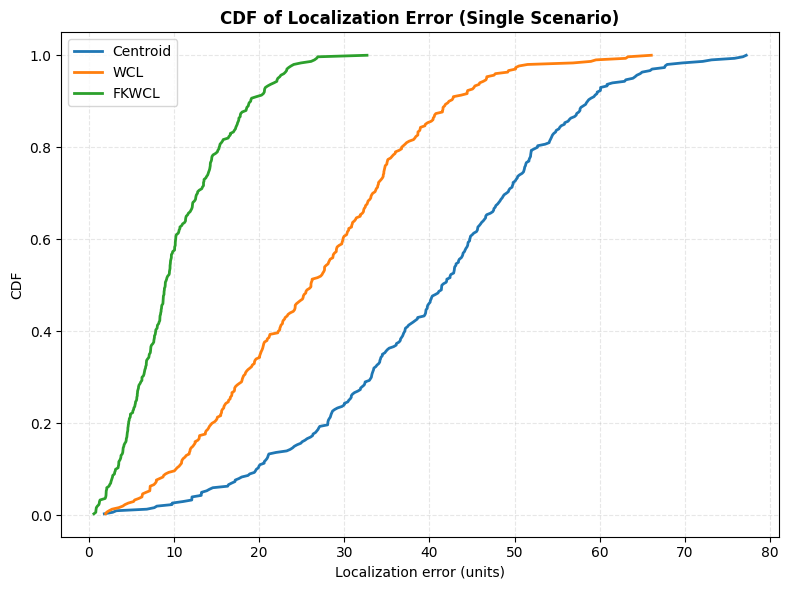

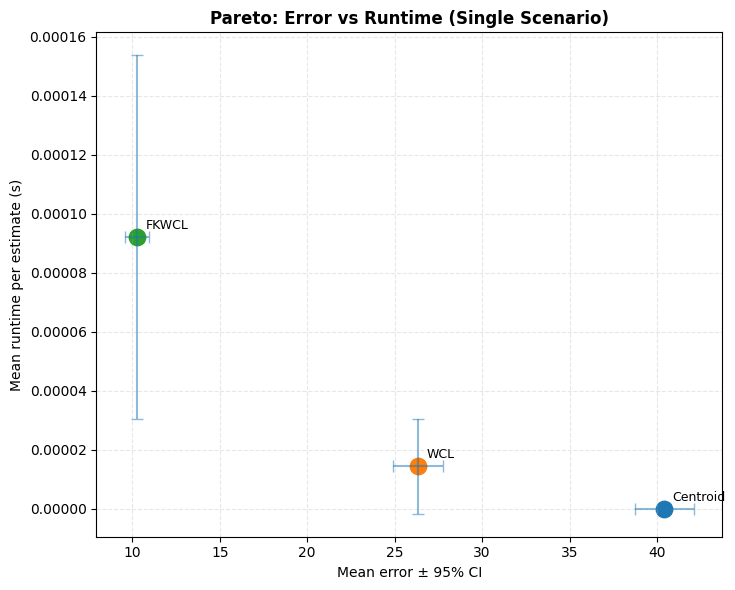

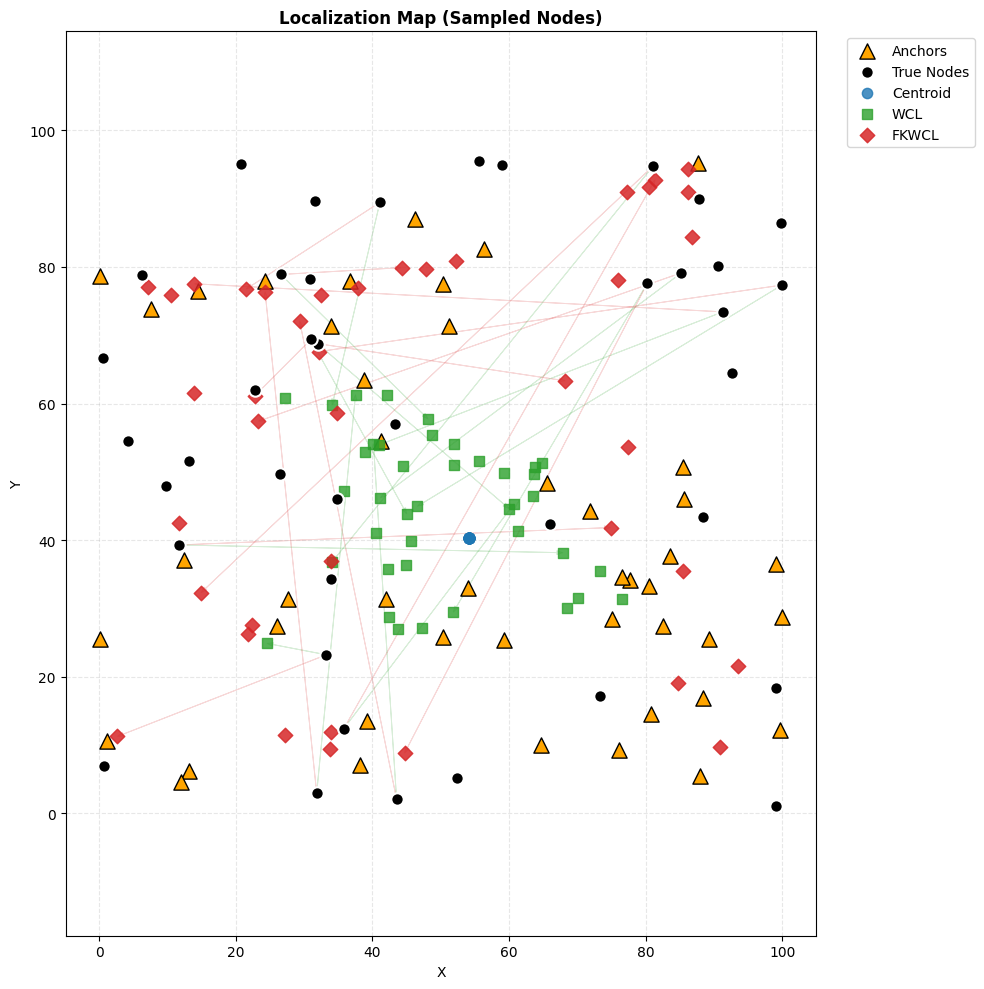

In [9]:
if __name__ == "__main__":
    metrics, raw = run_one_scenario(
        N=300,
        area_L=100.0,
        node_shape="square",            # square/C/L/U/W
        anchor_layout="random",    # random/grid/C/L/U/W
        anchor_ratio=0.15,
        n_pathloss=2.0,
        sigma_shadow=3.0,
        doi=0.3,                   # radio irregularity
        n_assumed=2.0,
        K=6, alpha=0.10,           # FKWCL parameters
        p_wcl=1.0,
        rng_seed=np.random.randint(0, 10000)
    )

    print("\n=== Single Scenario Results (mean ± 95% CI, median, Q90, Q95) ===")
    for m in ["Centroid","WCL","FKWCL"]:
        acc = metrics[m]["accuracy"]
        print(f"{m:9s}: {acc['mean']:.2f} ± {acc['ci95']:.2f}  | "
              f"median={acc['median']:.2f}  q90={acc['q90']:.2f}  q95={acc['q95']:.2f}  "
              f"| runtime={metrics[m]['runtime_mean']:.6f}s")

    plot_error_cdf(raw["errors"], title="CDF of Localization Error (Single Scenario)")
    plot_pareto(metrics, title="Pareto: Error vs Runtime (Single Scenario)")
    plot_localization_map(raw["map"], title="Localization Map (Sampled Nodes)")

> Scenario ('square', 'grid', 0.1, 0.0)
> Scenario ('square', 'grid', 0.1, 0.2)
> Scenario ('square', 'grid', 0.1, 0.5)
> Scenario ('square', 'grid', 0.15, 0.0)
> Scenario ('square', 'grid', 0.15, 0.2)
> Scenario ('square', 'grid', 0.15, 0.5)
> Scenario ('square', 'grid', 0.2, 0.0)
> Scenario ('square', 'grid', 0.2, 0.2)
> Scenario ('square', 'grid', 0.2, 0.5)
> Scenario ('square', 'random', 0.1, 0.0)
> Scenario ('square', 'random', 0.1, 0.2)
> Scenario ('square', 'random', 0.1, 0.5)
> Scenario ('square', 'random', 0.15, 0.0)
> Scenario ('square', 'random', 0.15, 0.2)
> Scenario ('square', 'random', 0.15, 0.5)
> Scenario ('square', 'random', 0.2, 0.0)
> Scenario ('square', 'random', 0.2, 0.2)
> Scenario ('square', 'random', 0.2, 0.5)
> Scenario ('square', 'C', 0.1, 0.0)
> Scenario ('square', 'C', 0.1, 0.2)
> Scenario ('square', 'C', 0.1, 0.5)
> Scenario ('square', 'C', 0.15, 0.0)
> Scenario ('square', 'C', 0.15, 0.2)
> Scenario ('square', 'C', 0.15, 0.5)
> Scenario ('square', 'C', 0.2,

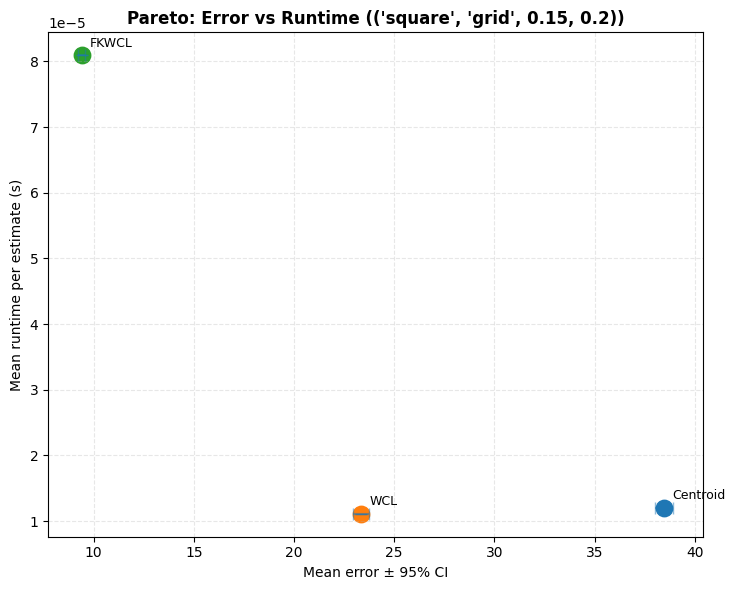

In [10]:
if __name__ == "__main__":
    # Define experiment parameters
    seeds = 10
    N = 200
    area_L = 100.0
    node_shapes = ("square", "C", "L", "U", "W")
    anchor_layouts = ("grid", "random", "C", "L", "U", "W")
    anchor_ratios = (0.1, 0.15, 0.2)
    dois = (0.0, 0.2, 0.5)
    n_pathloss = 2.0
    sigma_shadow = 3.0
    n_assumed = 2.0
    K = 8
    alpha = 0.05
    p_wcl = 1.0

    # Run the full experiment grid
    agg_results = run_experiment_grid(
        seeds=seeds,
        N=N,
        area_L=area_L,
        node_shapes=node_shapes,
        anchor_layouts=anchor_layouts,
        anchor_ratios=anchor_ratios,
        dois=dois,
        n_pathloss=n_pathloss,
        sigma_shadow=sigma_shadow,
        n_assumed=n_assumed,
        K=K,
        alpha=alpha,
        p_wcl=p_wcl,
        verbose=True
    )

    # Print summary for each scenario
    print("\n=== Aggregated Results Across All Scenarios ===")
    for key, methods in agg_results.items():
        print(f"\nScenario: node_shape={key[0]}, anchor_layout={key[1]}, anchor_ratio={key[2]}, DOI={key[3]}")
        for m in ["Centroid", "WCL", "FKWCL"]:
            res = methods[m]
            print(f"{m:9s}: mean={res['mean']:.2f} ± {res['mean_ci95']:.2f} | "
                  f"median={res['median']:.2f} | q90={res['q90']:.2f} | q95={res['q95']:.2f} | "
                  f"runtime={res['runtime']:.6f}s")

    # Optionally, plot Pareto for a selected scenario
    # Example: plot for node_shape="square", anchor_layout="grid", anchor_ratio=0.15, DOI=0.2
    scenario_key = ("square", "grid", 0.15, 0.2)
    if scenario_key in agg_results:
        metrics = {
            m: {
                "accuracy": {
                    "mean": agg_results[scenario_key][m]["mean"],
                    "ci95": agg_results[scenario_key][m]["mean_ci95"]
                },
                "runtime_mean": agg_results[scenario_key][m]["runtime"],
                "runtime_ci95": 0.0  # Not available in agg, set to 0
            } for m in ["Centroid", "WCL", "FKWCL"]
        }
        plot_pareto(metrics, title=f"Pareto: Error vs Runtime ({scenario_key})")

In [11]:
print(agg_results)

{('square', 'grid', 0.1, 0.0): {'Centroid': {'mean': 38.720666082169075, 'mean_ci95': 0.4424308041101848, 'median': 40.70546246475365, 'q90': 55.806324664752914, 'q95': 59.89504478439464, 'runtime': 4.624485969543457e-06}, 'WCL': {'mean': 23.095182883379074, 'mean_ci95': 0.6191191306105586, 'median': 22.164120027373848, 'q90': 37.624515293753674, 'q95': 41.59202945710929, 'runtime': 1.8282890319824218e-05}, 'FKWCL': {'mean': 9.670400176936148, 'mean_ci95': 0.32076712578469685, 'median': 8.475271212760934, 'q90': 17.594133278966357, 'q95': 20.374099457078607, 'runtime': 5.400431156158448e-05}}, ('square', 'grid', 0.1, 0.2): {'Centroid': {'mean': 38.720666082169075, 'mean_ci95': 0.4424308041101848, 'median': 40.70546246475365, 'q90': 55.806324664752914, 'q95': 59.89504478439464, 'runtime': 4.8179626464843755e-06}, 'WCL': {'mean': 23.101147690535374, 'mean_ci95': 0.6571743825828821, 'median': 22.417158928413784, 'q90': 37.81640382125663, 'q95': 41.6451118608381, 'runtime': 8.7953805923461


=== Scenario 1: anchor_layout=C, DOI=0.5, sigma_shadow=6.0 ===
Centroid : 38.46 ± 2.10  | median=40.02  q90=56.78  q95=61.65  | runtime=0.000016s
WCL      : 22.95 ± 1.60  | median=22.14  q90=39.41  q95=44.66  | runtime=0.000049s
FKWCL    : 17.58 ± 1.51  | median=16.16  q90=31.85  q95=39.58  | runtime=0.000129s


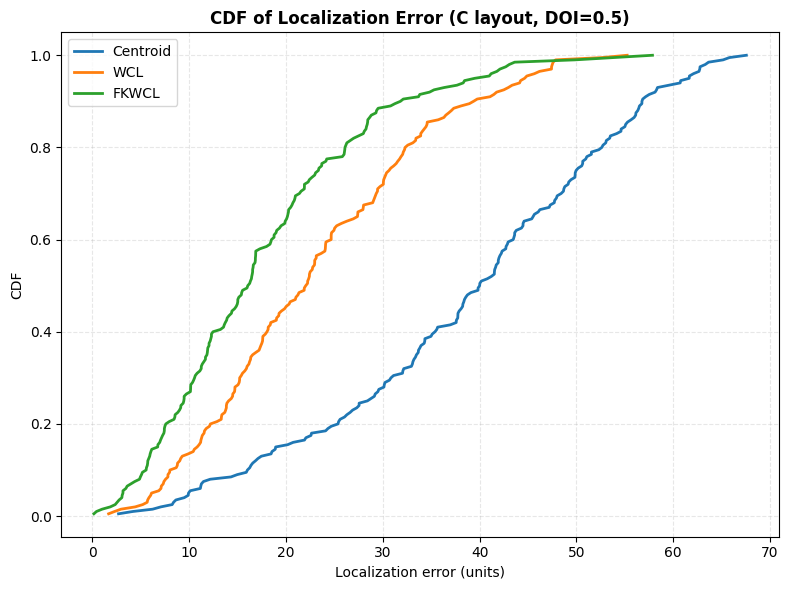

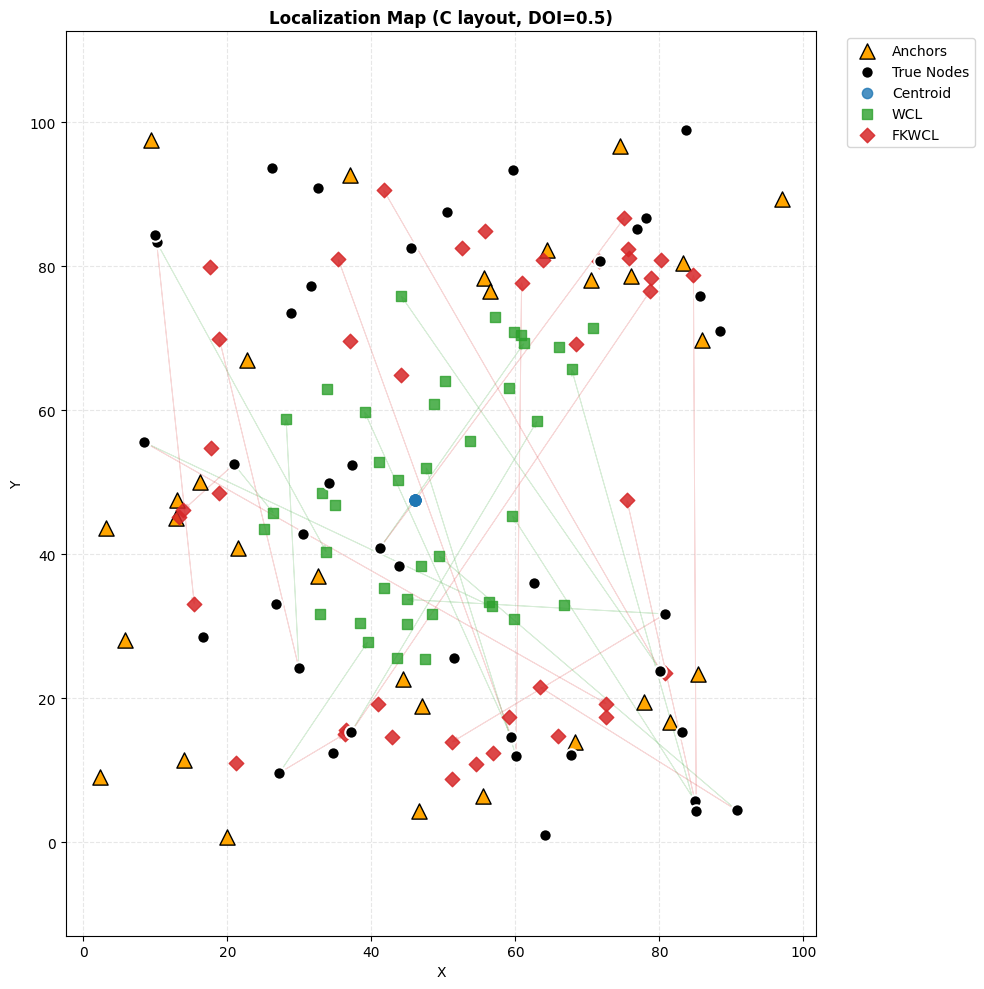


=== Scenario 2: anchor_layout=L, DOI=0.5, sigma_shadow=6.0 ===
Centroid : 41.37 ± 2.37  | median=42.24  q90=63.96  q95=68.67  | runtime=0.000000s
WCL      : 29.70 ± 2.30  | median=27.14  q90=53.49  q95=62.46  | runtime=0.000009s
FKWCL    : 23.02 ± 2.37  | median=17.54  q90=49.21  q95=57.24  | runtime=0.000092s


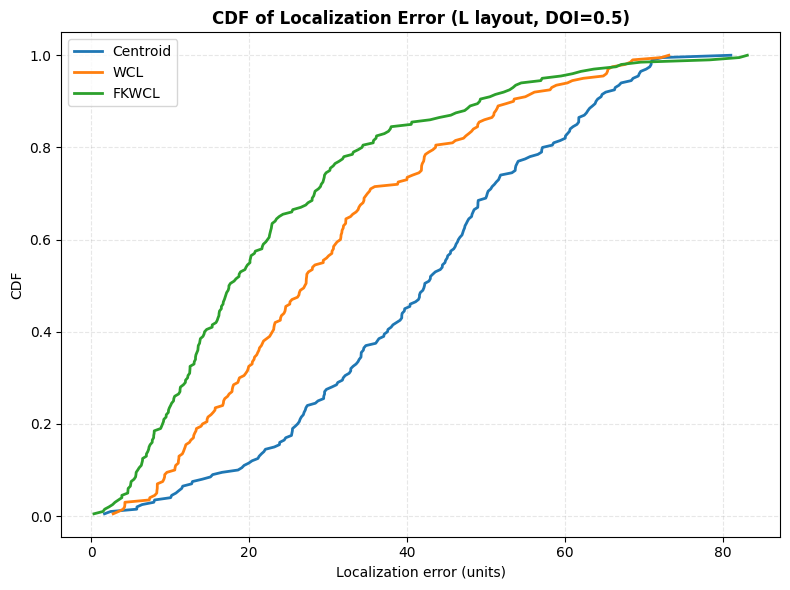

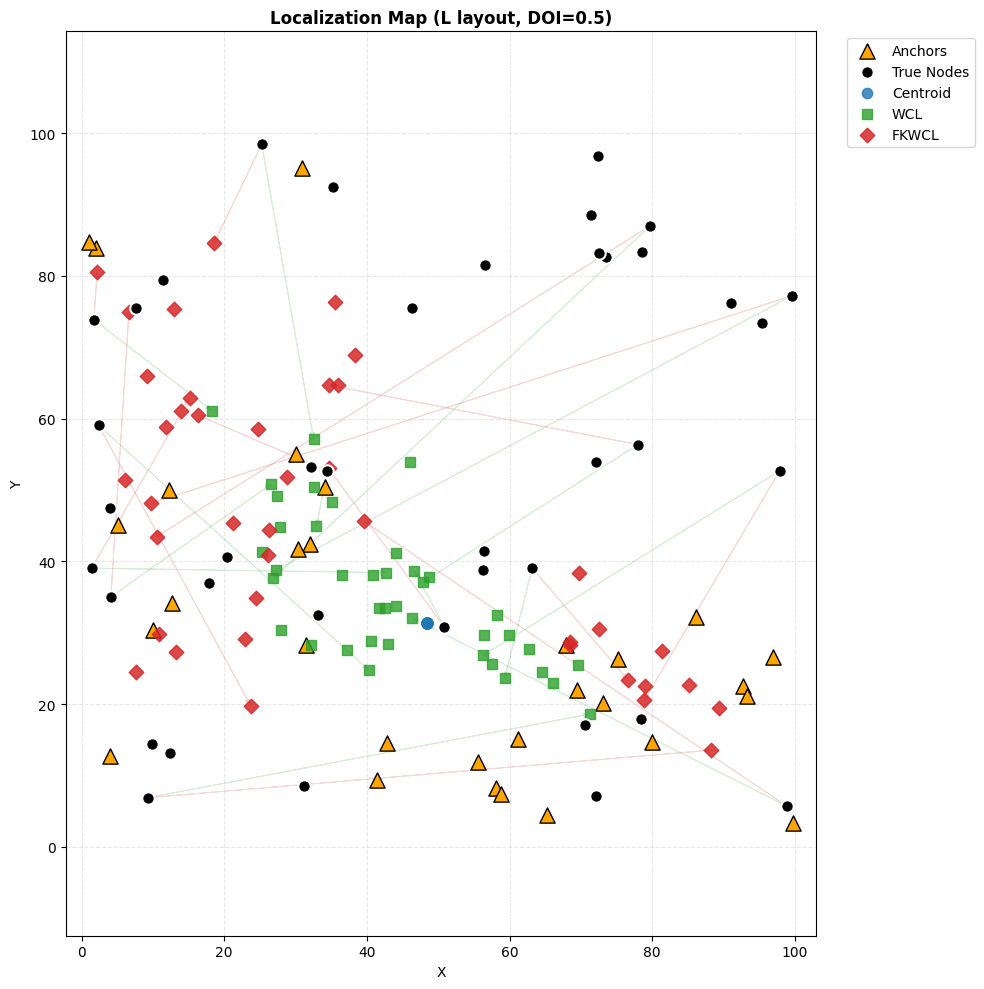


=== Scenario 3: anchor_layout=U, DOI=0.5, sigma_shadow=6.0 ===
Centroid : 38.54 ± 1.95  | median=38.46  q90=57.28  q95=60.75  | runtime=0.000028s
WCL      : 23.18 ± 1.48  | median=22.52  q90=37.63  q95=40.83  | runtime=0.000015s
FKWCL    : 17.58 ± 1.60  | median=15.32  q90=34.16  q95=38.81  | runtime=0.000122s


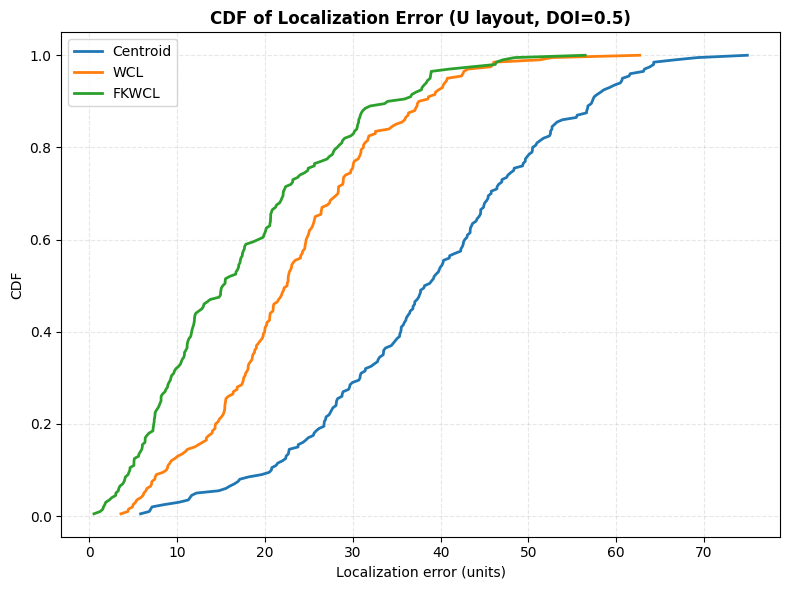

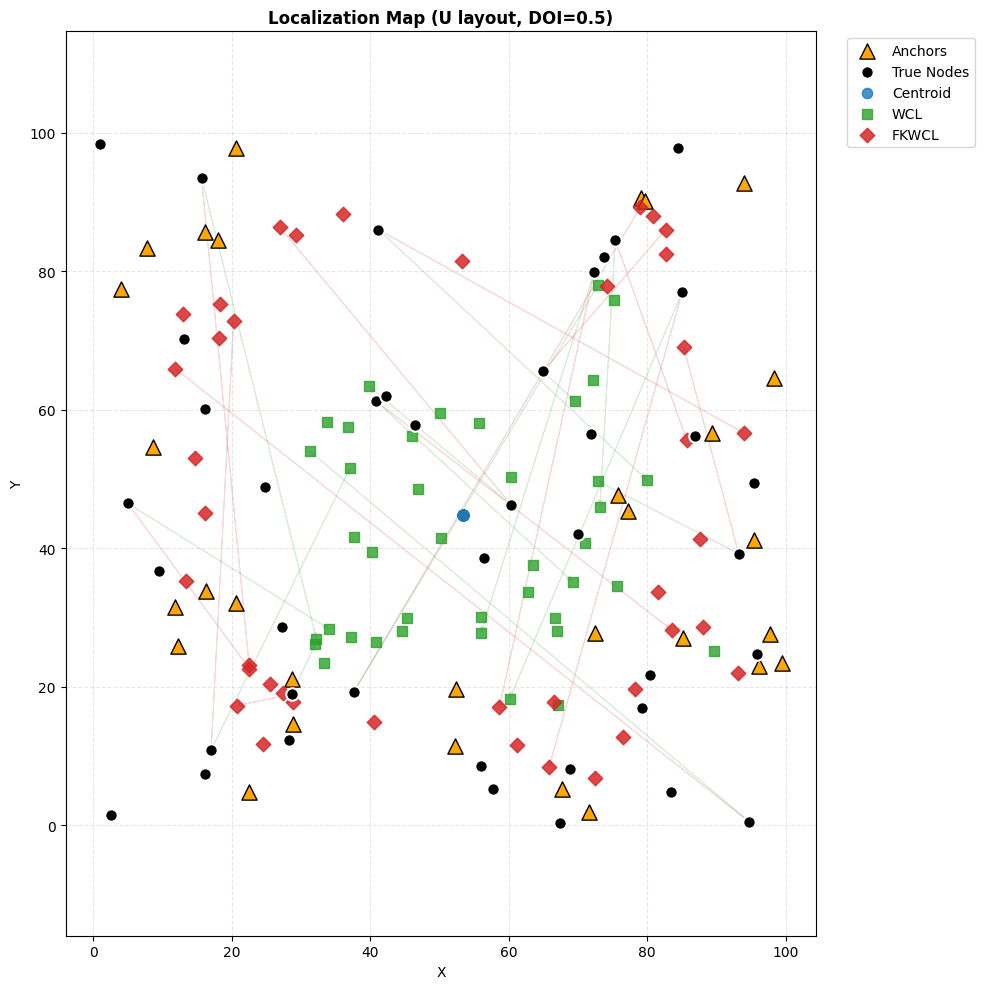

In [12]:
if __name__ == "__main__":
    scenarios = [
        {"node_shape": "square", "anchor_layout": "C", "anchor_ratio": 0.15, "doi": 0.5, "sigma_shadow": 6.0},
        {"node_shape": "square", "anchor_layout": "L", "anchor_ratio": 0.15, "doi": 0.5, "sigma_shadow": 6.0},
        {"node_shape": "square", "anchor_layout": "U", "anchor_ratio": 0.15, "doi": 0.5, "sigma_shadow": 6.0},
    ]
    for i, params in enumerate(scenarios):
        print(f"\n=== Scenario {i+1}: anchor_layout={params['anchor_layout']}, DOI={params['doi']}, sigma_shadow={params['sigma_shadow']} ===")
        metrics, raw = run_one_scenario(
            N=200,
            area_L=100.0,
            node_shape=params["node_shape"],
            anchor_layout=params["anchor_layout"],
            anchor_ratio=params["anchor_ratio"],
            n_pathloss=2.0,
            sigma_shadow=params["sigma_shadow"],
            doi=params["doi"],
            n_assumed=2.0,
            K=8, alpha=0.05,
            p_wcl=1.0,
            rng_seed=42 + i
        )
        for m in ["Centroid","WCL","FKWCL"]:
            acc = metrics[m]["accuracy"]
            print(f"{m:9s}: {acc['mean']:.2f} ± {acc['ci95']:.2f}  | "
                  f"median={acc['median']:.2f}  q90={acc['q90']:.2f}  q95={acc['q95']:.2f}  "
                  f"| runtime={metrics[m]['runtime_mean']:.6f}s")
        plot_error_cdf(raw["errors"], title=f"CDF of Localization Error ({params['anchor_layout']} layout, DOI={params['doi']})")
        plot_localization_map(raw["map"], title=f"Localization Map ({params['anchor_layout']} layout, DOI={params['doi']})")

# Simulation & Evaluation

## Different node shapes


=== IR: Node Shape Comparison ===

Node shape: square
Centroid : mean=38.46 ± 0.46 | median=40.12 | q90=55.89 | q95=59.90 | runtime=0.000019s
WCL      : mean=23.33 ± 0.40 | median=22.40 | q90=38.53 | q95=42.18 | runtime=0.000013s
FKWCL    : mean=9.39 ± 0.18 | median=8.52 | q90=16.87 | q95=19.03 | runtime=0.000108s

Node shape: C
Centroid : mean=43.96 ± 0.26 | median=44.39 | q90=57.48 | q95=61.33 | runtime=0.000015s
WCL      : mean=27.00 ± 0.42 | median=26.42 | q90=39.77 | q95=43.70 | runtime=0.000024s
FKWCL    : mean=9.54 ± 0.30 | median=8.63 | q90=17.02 | q95=19.55 | runtime=0.000087s

Node shape: L
Centroid : mean=42.42 ± 0.71 | median=43.18 | q90=57.94 | q95=61.09 | runtime=0.000011s
WCL      : mean=25.93 ± 0.68 | median=25.05 | q90=39.95 | q95=43.96 | runtime=0.000011s
FKWCL    : mean=9.43 ± 0.29 | median=8.42 | q90=17.11 | q95=19.46 | runtime=0.000112s

Node shape: U
Centroid : mean=43.68 ± 0.56 | median=44.11 | q90=58.15 | q95=61.43 | runtime=0.000018s
WCL      : mean=26.72 ± 0.

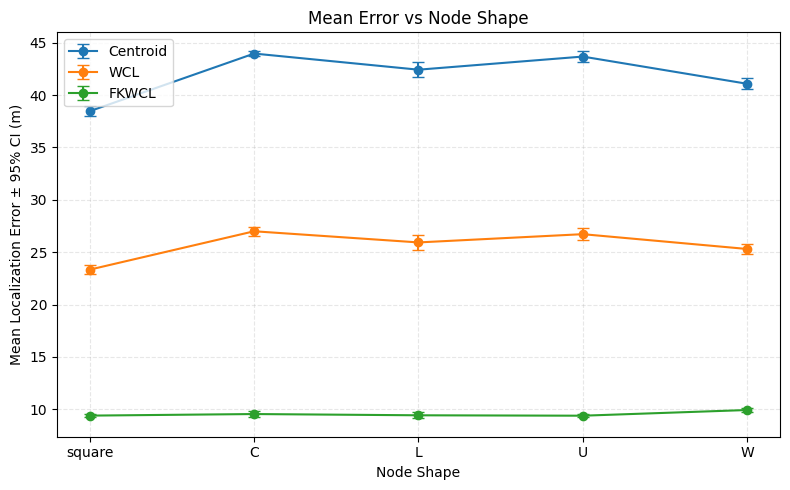

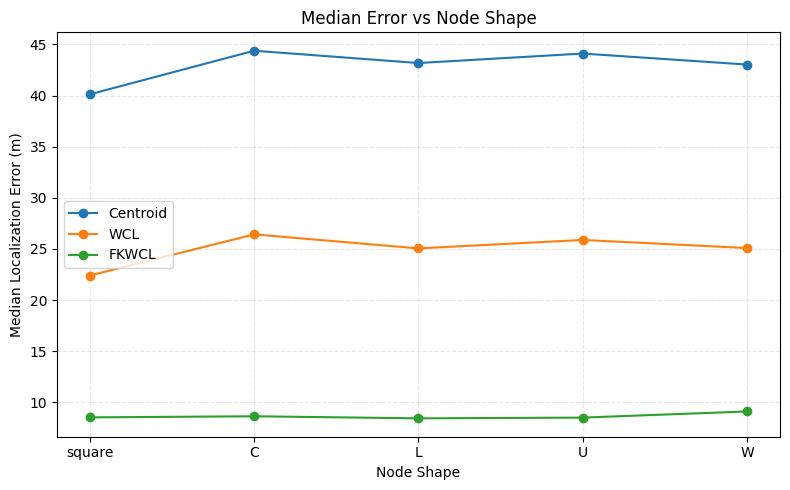

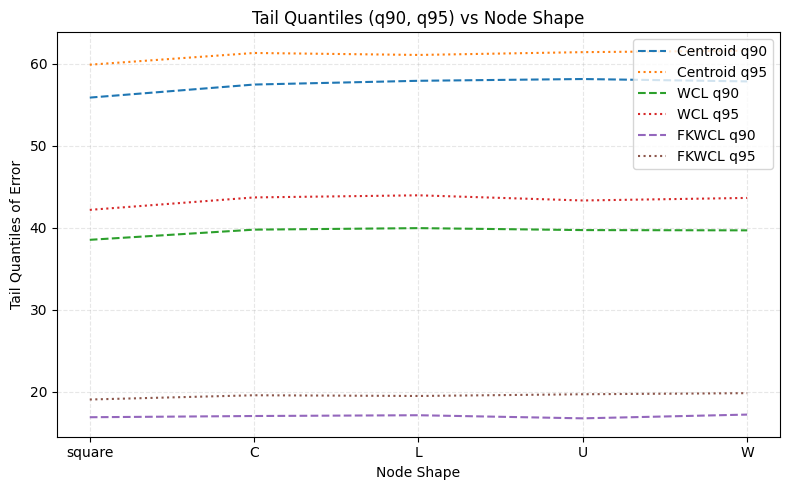

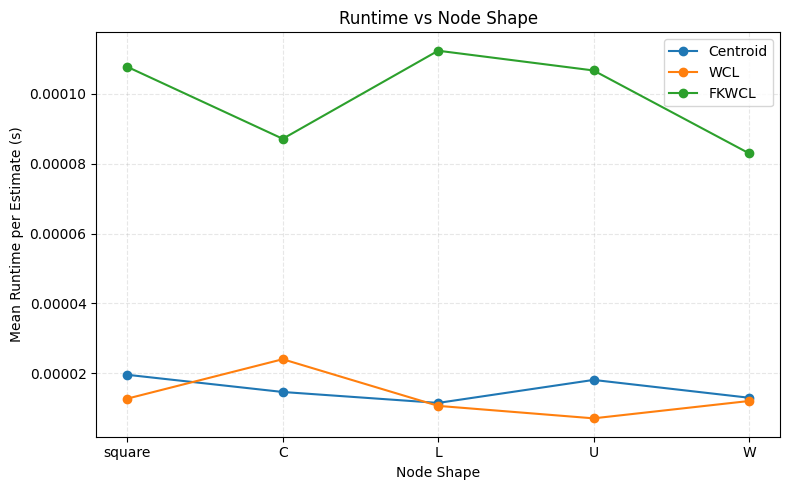

In [13]:
node_shapes = ["square", "C", "L", "U", "W"]
methods = ["Centroid", "WCL", "FKWCL"]

mean_errors = {m: [] for m in methods}
mean_cis = {m: [] for m in methods}
medians = {m: [] for m in methods}
q90s = {m: [] for m in methods}
q95s = {m: [] for m in methods}
runtimes = {m: [] for m in methods}

fixed_params = dict(
    anchor_layout="grid",
    anchor_ratio=0.15,
    doi=0.2,
    N=200,
    area_L=100.0,
    n_pathloss=2.0,
    sigma_shadow=3.0,
    n_assumed=2.0,
    K=8,
    alpha=0.05,
    p_wcl=1.0,
    seeds=10
)
print("\n=== IR: Node Shape Comparison ===")
for shape in node_shapes:
    agg = run_experiment_grid(
        seeds=fixed_params["seeds"],
        N=fixed_params["N"],
        area_L=fixed_params["area_L"],
        node_shapes=(shape,),
        anchor_layouts=(fixed_params["anchor_layout"],),
        anchor_ratios=(fixed_params["anchor_ratio"],),
        dois=(fixed_params["doi"],),
        n_pathloss=fixed_params["n_pathloss"],
        sigma_shadow=fixed_params["sigma_shadow"],
        n_assumed=fixed_params["n_assumed"],
        K=fixed_params["K"],
        alpha=fixed_params["alpha"],
        p_wcl=fixed_params["p_wcl"],
        verbose=False
    )
    key = (shape, fixed_params["anchor_layout"], fixed_params["anchor_ratio"], fixed_params["doi"])
    print(f"\nNode shape: {shape}")
    for m in methods:
        res = agg[key][m]
        print(f"{m:9s}: mean={res['mean']:.2f} ± {res['mean_ci95']:.2f} | median={res['median']:.2f} | q90={res['q90']:.2f} | q95={res['q95']:.2f} | runtime={res['runtime']:.6f}s")
        mean_errors[m].append(res["mean"])
        mean_cis[m].append(res["mean_ci95"])
        medians[m].append(res["median"])
        q90s[m].append(res["q90"])
        q95s[m].append(res["q95"])
        runtimes[m].append(res["runtime"])

# Plot mean error with CI
plt.figure(figsize=(8,5))
for m in methods:
    plt.errorbar(node_shapes, mean_errors[m], yerr=mean_cis[m], label=m, marker='o', capsize=4)
plt.xlabel("Node Shape")
plt.ylabel("Mean Localization Error ± 95% CI (m)")
plt.title("Mean Error vs Node Shape")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot median error
plt.figure(figsize=(8,5))
for m in methods:
    plt.plot(node_shapes, medians[m], label=m, marker='o')
plt.xlabel("Node Shape")
plt.ylabel("Median Localization Error (m)")
plt.title("Median Error vs Node Shape")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot q90 and q95
plt.figure(figsize=(8,5))
for m in methods:
    plt.plot(node_shapes, q90s[m], label=f"{m} q90", linestyle='--')
    plt.plot(node_shapes, q95s[m], label=f"{m} q95", linestyle=':')
plt.xlabel("Node Shape")
plt.ylabel("Tail Quantiles of Error")
plt.title("Tail Quantiles (q90, q95) vs Node Shape")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot runtime
plt.figure(figsize=(8,5))
for m in methods:
    plt.plot(node_shapes, runtimes[m], label=m, marker='o')
plt.xlabel("Node Shape")
plt.ylabel("Mean Runtime per Estimate (s)")
plt.title("Runtime vs Node Shape")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

## Different Anchor Ratios


=== IR: Anchor Ratio Comparison ===

Anchor ratio: 0.01
Centroid : mean=41.86 ± 0.74 | median=41.31 | q90=64.13 | q95=68.73 | runtime=0.000006s
WCL      : mean=27.32 ± 0.90 | median=21.99 | q90=55.44 | q95=64.86 | runtime=0.000014s
FKWCL    : mean=28.46 ± 0.85 | median=24.45 | q90=56.85 | q95=66.81 | runtime=0.000092s

Anchor ratio: 0.05
Centroid : mean=39.24 ± 0.78 | median=39.93 | q90=58.48 | q95=63.12 | runtime=0.000009s
WCL      : mean=25.01 ± 1.18 | median=22.92 | q90=44.28 | q95=51.56 | runtime=0.000023s
FKWCL    : mean=14.76 ± 0.95 | median=11.78 | q90=30.73 | q95=37.63 | runtime=0.000094s

Anchor ratio: 0.25
Centroid : mean=38.35 ± 0.49 | median=39.97 | q90=55.65 | q95=59.76 | runtime=0.000005s
WCL      : mean=23.72 ± 0.60 | median=22.41 | q90=39.29 | q95=44.09 | runtime=0.000028s
FKWCL    : mean=9.04 ± 0.22 | median=8.25 | q90=15.94 | q95=18.24 | runtime=0.000111s

Anchor ratio: 0.5
Centroid : mean=38.35 ± 0.43 | median=40.07 | q90=55.28 | q95=58.88 | runtime=0.000004s
WCL   

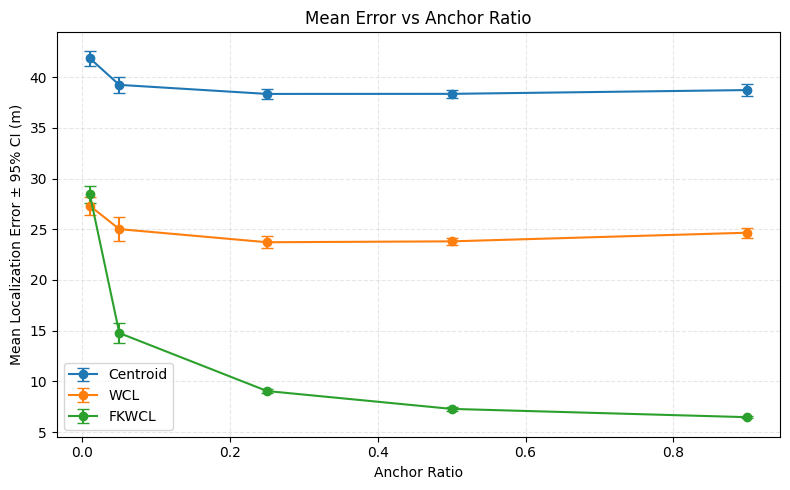

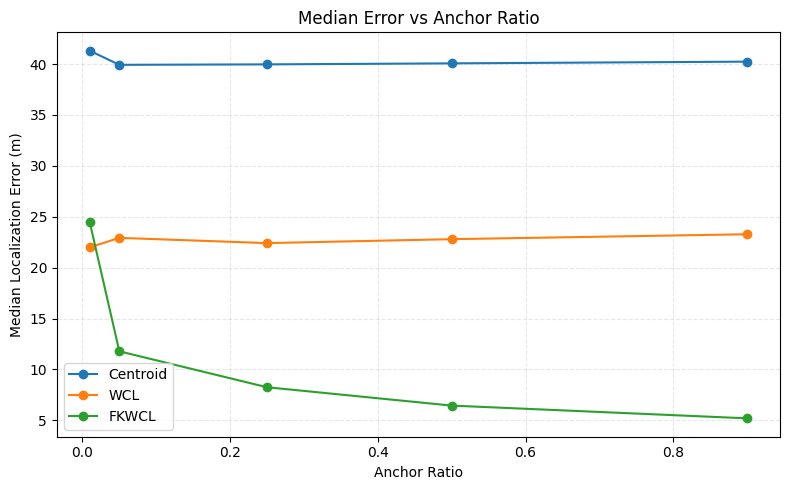

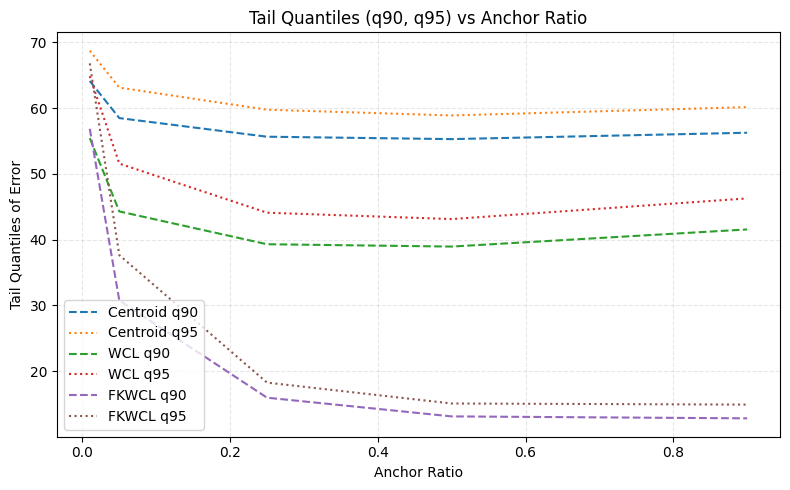

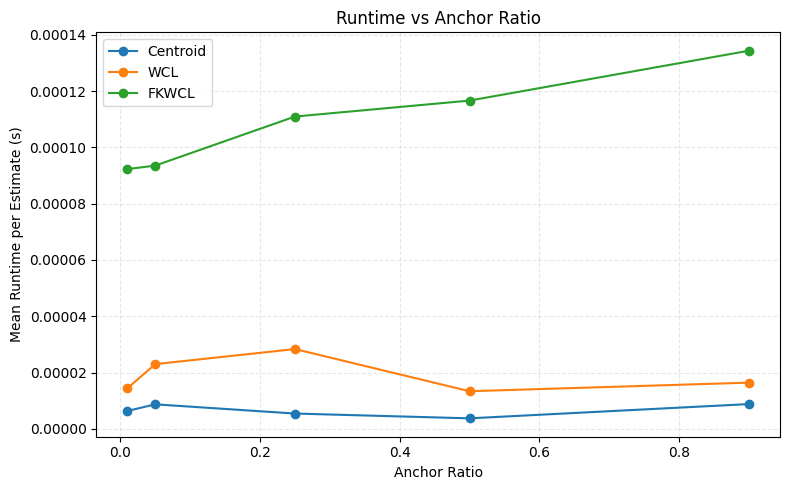

In [14]:
anchor_ratios = [0.01, 0.05, 0.25, 0.5, 0.9]
methods = ["Centroid", "WCL", "FKWCL"]

mean_errors = {m: [] for m in methods}
mean_cis = {m: [] for m in methods}
medians = {m: [] for m in methods}
q90s = {m: [] for m in methods}
q95s = {m: [] for m in methods}
runtimes = {m: [] for m in methods}

print("\n=== IR: Anchor Ratio Comparison ===")
for ar in anchor_ratios:
    agg = run_experiment_grid(
        seeds=fixed_params["seeds"],
        N=fixed_params["N"],
        area_L=fixed_params["area_L"],
        node_shapes=("square",),
        anchor_layouts=(fixed_params["anchor_layout"],),
        anchor_ratios=(ar,),
        dois=(fixed_params["doi"],),
        n_pathloss=fixed_params["n_pathloss"],
        sigma_shadow=fixed_params["sigma_shadow"],
        n_assumed=fixed_params["n_assumed"],
        K=fixed_params["K"],
        alpha=fixed_params["alpha"],
        p_wcl=fixed_params["p_wcl"],
        verbose=False
    )
    key = ("square", fixed_params["anchor_layout"], ar, fixed_params["doi"])
    print(f"\nAnchor ratio: {ar}")
    for m in methods:
        res = agg[key][m]
        print(f"{m:9s}: mean={res['mean']:.2f} ± {res['mean_ci95']:.2f} | median={res['median']:.2f} | q90={res['q90']:.2f} | q95={res['q95']:.2f} | runtime={res['runtime']:.6f}s")
        mean_errors[m].append(res["mean"])
        mean_cis[m].append(res["mean_ci95"])
        medians[m].append(res["median"])
        q90s[m].append(res["q90"])
        q95s[m].append(res["q95"])
        runtimes[m].append(res["runtime"])

# Plot mean error with CI
plt.figure(figsize=(8,5))
for m in methods:
    plt.errorbar(anchor_ratios, mean_errors[m], yerr=mean_cis[m], label=m, marker='o', capsize=4)
plt.xlabel("Anchor Ratio")
plt.ylabel("Mean Localization Error ± 95% CI (m)")
plt.title("Mean Error vs Anchor Ratio")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot median error
plt.figure(figsize=(8,5))
for m in methods:
    plt.plot(anchor_ratios, medians[m], label=m, marker='o')
plt.xlabel("Anchor Ratio")
plt.ylabel("Median Localization Error (m)")
plt.title("Median Error vs Anchor Ratio")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot q90 and q95
plt.figure(figsize=(8,5))
for m in methods:
    plt.plot(anchor_ratios, q90s[m], label=f"{m} q90", linestyle='--')
    plt.plot(anchor_ratios, q95s[m], label=f"{m} q95", linestyle=':')
plt.xlabel("Anchor Ratio")
plt.ylabel("Tail Quantiles of Error")
plt.title("Tail Quantiles (q90, q95) vs Anchor Ratio")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot runtime
plt.figure(figsize=(8,5))
for m in methods:
    plt.plot(anchor_ratios, runtimes[m], label=m, marker='o')
plt.xlabel("Anchor Ratio")
plt.ylabel("Mean Runtime per Estimate (s)")
plt.title("Runtime vs Anchor Ratio")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

## Different DOI


=== IR: DOI Comparison ===

DOI: 0.0
Centroid : mean=38.46 ± 0.46 | median=40.12 | q90=55.89 | q95=59.90 | runtime=0.000022s
WCL      : mean=23.10 ± 0.42 | median=22.03 | q90=38.06 | q95=41.74 | runtime=0.000009s
FKWCL    : mean=8.47 ± 0.22 | median=7.57 | q90=15.56 | q95=18.27 | runtime=0.000106s

DOI: 0.2
Centroid : mean=38.46 ± 0.46 | median=40.12 | q90=55.89 | q95=59.90 | runtime=0.000017s
WCL      : mean=23.33 ± 0.40 | median=22.40 | q90=38.53 | q95=42.18 | runtime=0.000010s
FKWCL    : mean=9.39 ± 0.18 | median=8.52 | q90=16.87 | q95=19.03 | runtime=0.000123s

DOI: 0.6
Centroid : mean=38.46 ± 0.46 | median=40.12 | q90=55.89 | q95=59.90 | runtime=0.000017s
WCL      : mean=23.74 ± 0.37 | median=23.00 | q90=38.80 | q95=43.05 | runtime=0.000024s
FKWCL    : mean=15.22 ± 0.32 | median=14.67 | q90=24.37 | q95=27.18 | runtime=0.000117s

DOI: 0.9
Centroid : mean=38.46 ± 0.46 | median=40.12 | q90=55.89 | q95=59.90 | runtime=0.000014s
WCL      : mean=25.22 ± 0.34 | median=25.27 | q90=41.50 

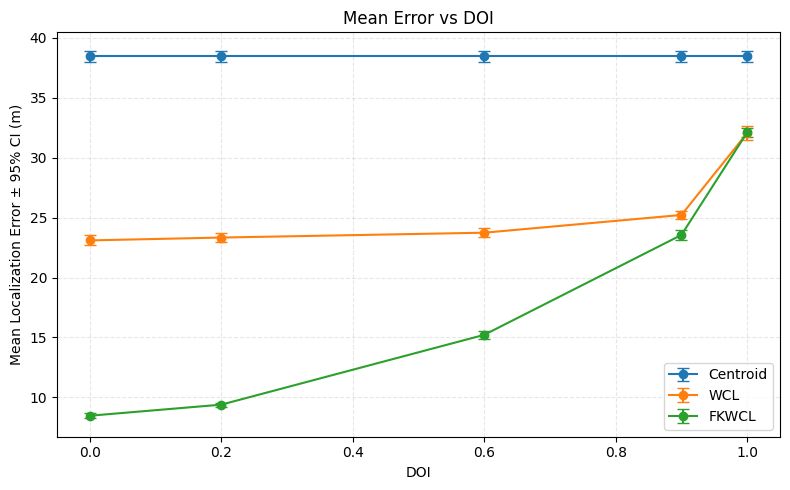

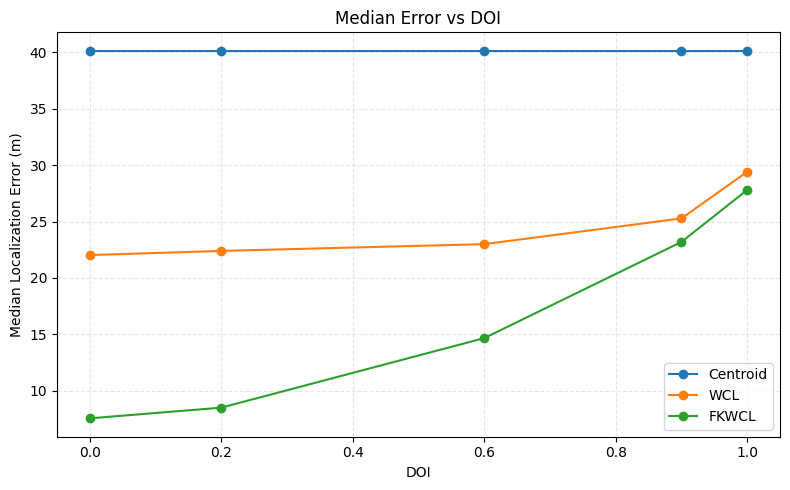

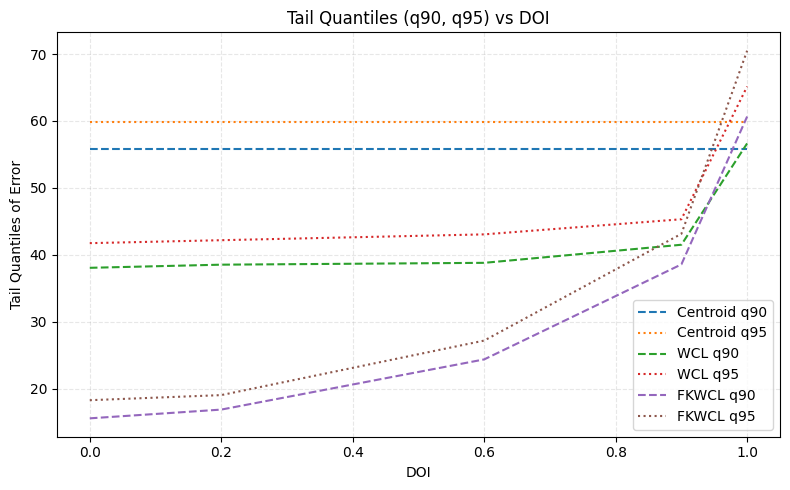

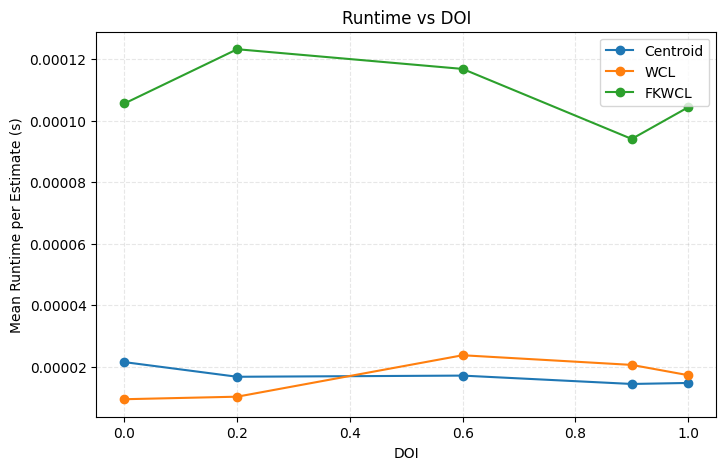

In [15]:
dois = [0.0, 0.2, 0.6, 0.9, 1]
methods = ["Centroid", "WCL", "FKWCL"]

mean_errors = {m: [] for m in methods}
mean_cis = {m: [] for m in methods}
medians = {m: [] for m in methods}
q90s = {m: [] for m in methods}
q95s = {m: [] for m in methods}
runtimes = {m: [] for m in methods}
print("\n=== IR: DOI Comparison ===")
for doi in dois:
    agg = run_experiment_grid(
        seeds=fixed_params["seeds"],
        N=fixed_params["N"],
        area_L=fixed_params["area_L"],
        node_shapes=("square",),
        anchor_layouts=(fixed_params["anchor_layout"],),
        anchor_ratios=(fixed_params["anchor_ratio"],),
        dois=(doi,),
        n_pathloss=fixed_params["n_pathloss"],
        sigma_shadow=fixed_params["sigma_shadow"],
        n_assumed=fixed_params["n_assumed"],
        K=fixed_params["K"],
        alpha=fixed_params["alpha"],
        p_wcl=fixed_params["p_wcl"],
        verbose=False
    )
    key = ("square", fixed_params["anchor_layout"], fixed_params["anchor_ratio"], doi)
    print(f"\nDOI: {doi}")
    for m in methods:
        res = agg[key][m]
        print(f"{m:9s}: mean={res['mean']:.2f} ± {res['mean_ci95']:.2f} | median={res['median']:.2f} | q90={res['q90']:.2f} | q95={res['q95']:.2f} | runtime={res['runtime']:.6f}s")
        mean_errors[m].append(res["mean"])
        mean_cis[m].append(res["mean_ci95"])
        medians[m].append(res["median"])
        q90s[m].append(res["q90"])
        q95s[m].append(res["q95"])
        runtimes[m].append(res["runtime"])

# Plot mean error with CI
plt.figure(figsize=(8,5))
for m in methods:
    plt.errorbar(dois, mean_errors[m], yerr=mean_cis[m], label=m, marker='o', capsize=4)
plt.xlabel("DOI")
plt.ylabel("Mean Localization Error ± 95% CI (m)")
plt.title("Mean Error vs DOI")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot median error
plt.figure(figsize=(8,5))
for m in methods:
    plt.plot(dois, medians[m], label=m, marker='o')
plt.xlabel("DOI")
plt.ylabel("Median Localization Error (m)")
plt.title("Median Error vs DOI")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot q90 and q95
plt.figure(figsize=(8,5))
for m in methods:
    plt.plot(dois, q90s[m], label=f"{m} q90", linestyle='--')
    plt.plot(dois, q95s[m], label=f"{m} q95", linestyle=':')
plt.xlabel("DOI")
plt.ylabel("Tail Quantiles of Error")
plt.title("Tail Quantiles (q90, q95) vs DOI")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot runtime
plt.figure(figsize=(8,5))
for m in methods:
    plt.plot(dois, runtimes[m], label=m, marker='o')
plt.xlabel("DOI")
plt.ylabel("Mean Runtime per Estimate (s)")
plt.title("Runtime vs DOI")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)

### Mean Error vs Node Shape

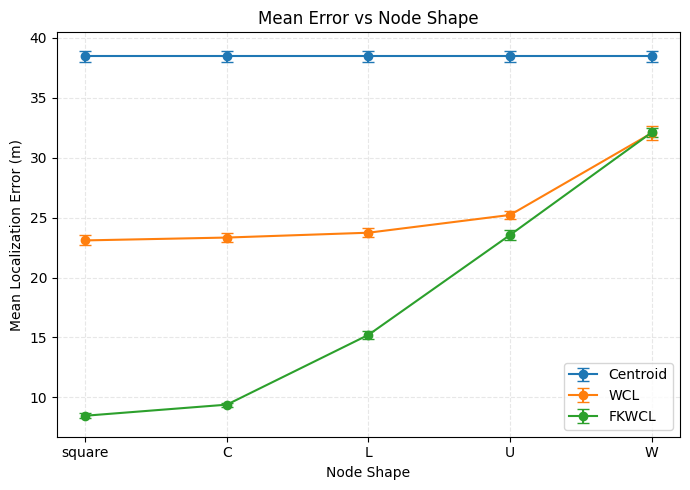

In [16]:
plt.figure(figsize=(7,5))
for m in methods:
    plt.errorbar(
        node_shapes, mean_errors[m], yerr=mean_cis[m], label=m, marker='o', capsize=4
    )
plt.xlabel("Node Shape")
plt.ylabel("Mean Localization Error (m)")
plt.title("Mean Error vs Node Shape")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

### Mean Error vs Anchor Ratio

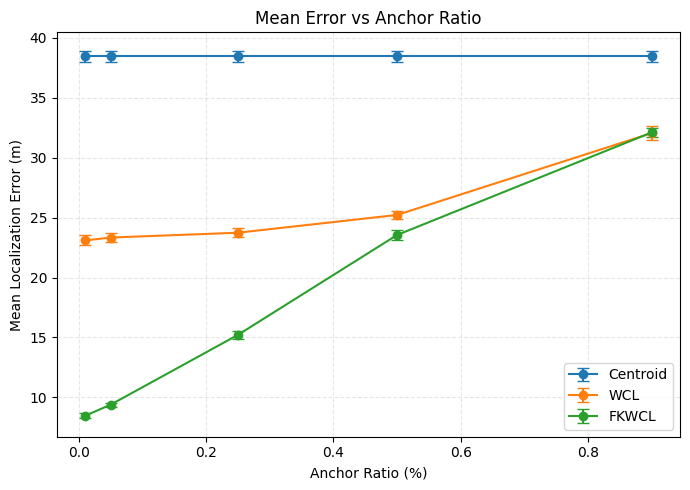

In [17]:
plt.figure(figsize=(7,5))
for m in methods:
    plt.errorbar(
        anchor_ratios, mean_errors[m], yerr=mean_cis[m], label=m, marker='o', capsize=4
    )
plt.xlabel("Anchor Ratio (%)")
plt.ylabel("Mean Localization Error (m)")
plt.title("Mean Error vs Anchor Ratio")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

### Mean Error vs DOI

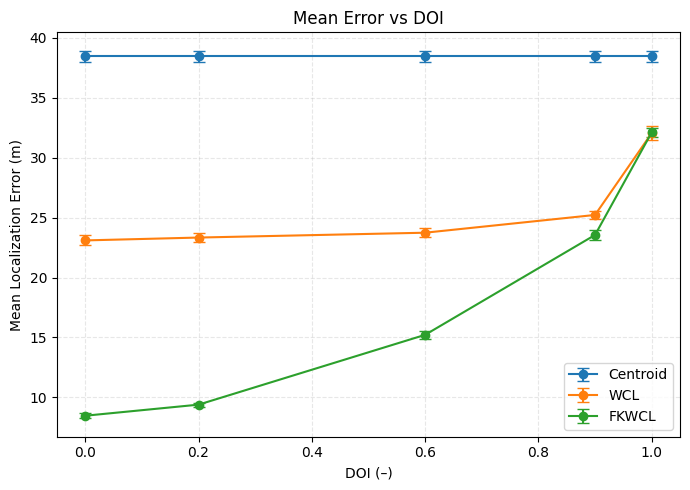

In [18]:
plt.figure(figsize=(7,5))
for m in methods:
    plt.errorbar(
        dois, mean_errors[m], yerr=mean_cis[m], label=m, marker='o', capsize=4
    )
plt.xlabel("DOI (–)")
plt.ylabel("Mean Localization Error (m)")
plt.title("Mean Error vs DOI")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

### Runtime vs Anchor Ratio

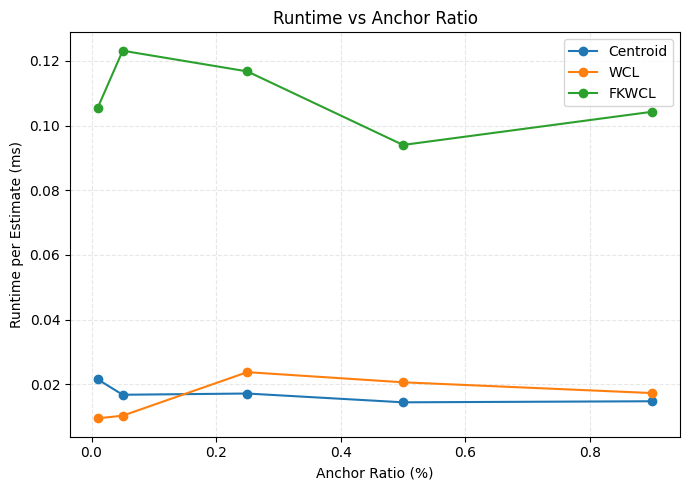

In [19]:
plt.figure(figsize=(7,5))
for m in methods:
    plt.plot(
        anchor_ratios, [1000*x for x in runtimes[m]], label=m, marker='o'
    )
plt.xlabel("Anchor Ratio (%)")
plt.ylabel("Runtime per Estimate (ms)")
plt.title("Runtime vs Anchor Ratio")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

### Median Error vs Node Shape

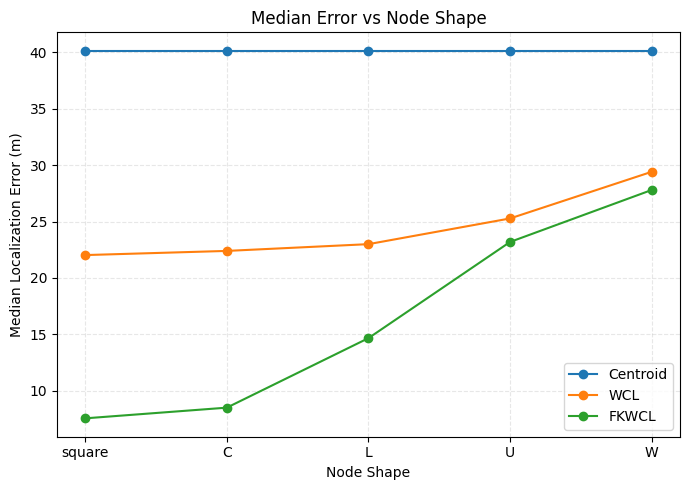

In [20]:
plt.figure(figsize=(7,5))
for m in methods:
    plt.plot(node_shapes, medians[m], label=m, marker='o')
plt.xlabel("Node Shape")
plt.ylabel("Median Localization Error (m)")
plt.title("Median Error vs Node Shape")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

### Median Error vs Anchor Ratio

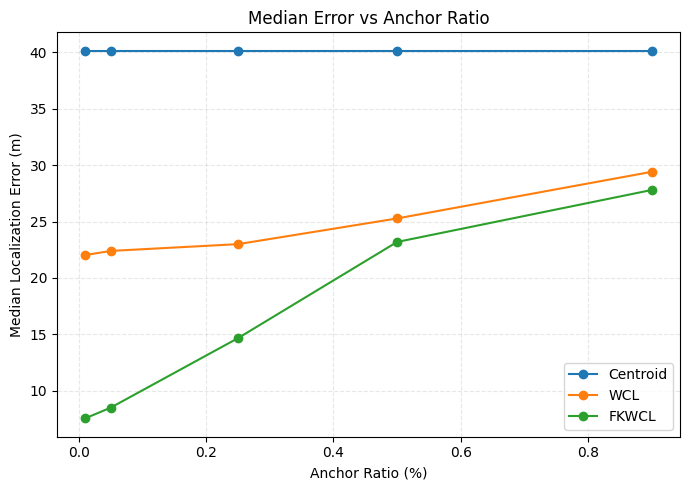

In [21]:
plt.figure(figsize=(7,5))
for m in methods:
    plt.plot(anchor_ratios, medians[m], label=m, marker='o')
plt.xlabel("Anchor Ratio (%)")
plt.ylabel("Median Localization Error (m)")
plt.title("Median Error vs Anchor Ratio")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

### Median Error vs DOI

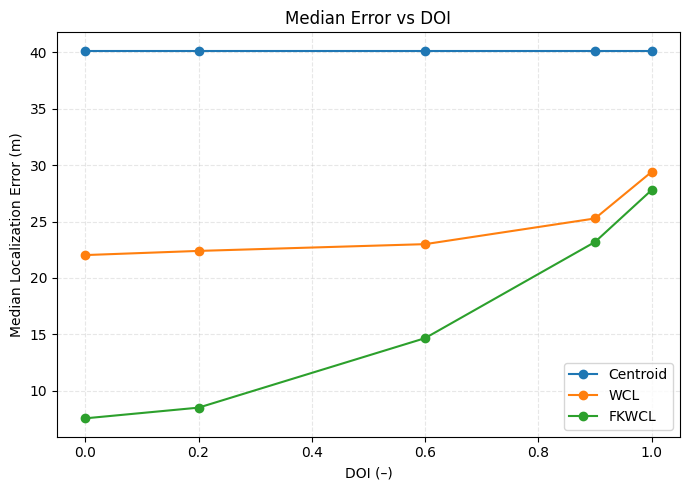

In [22]:
plt.figure(figsize=(7,5))
for m in methods:
    plt.plot(dois, medians[m], label=m, marker='o')
plt.xlabel("DOI (–)")
plt.ylabel("Median Localization Error (m)")
plt.title("Median Error vs DOI")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

### Runtime vs Node Shape

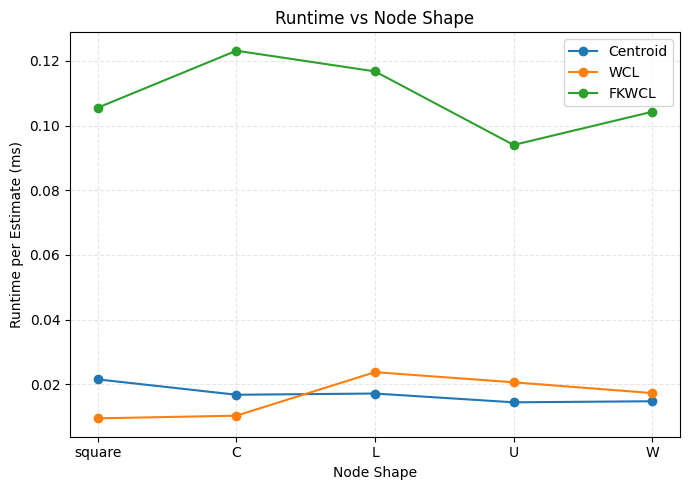

In [23]:
plt.figure(figsize=(7,5))
for m in methods:
    plt.plot(node_shapes, [1000*x for x in runtimes[m]], label=m, marker='o')
plt.xlabel("Node Shape")
plt.ylabel("Runtime per Estimate (ms)")
plt.title("Runtime vs Node Shape")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()